Tie inclusive rank

full data

--- ML Attack (varying N) ---


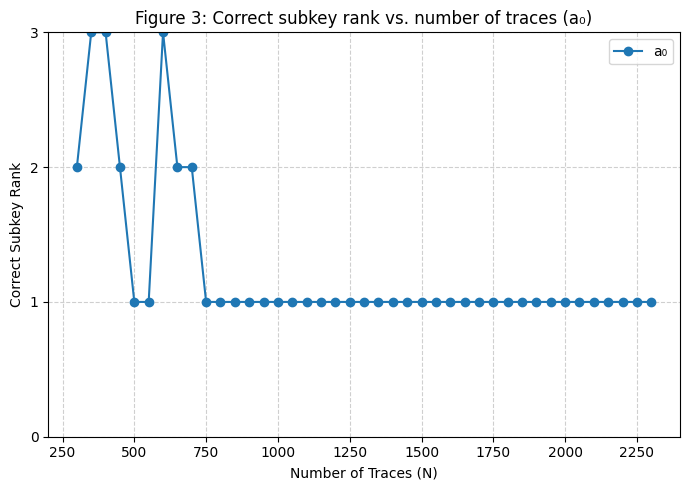

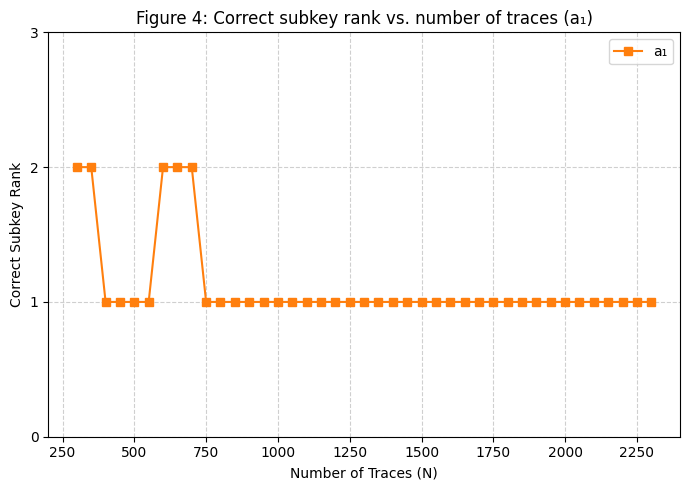

In [1]:
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

KYBER_Q = 3329
QINV = -3327

def int16(x: int) -> int:
    x = x & 0xFFFF
    return x - 0x10000 if x & 0x8000 else x

def uint16(x: int) -> int:
    return x & 0xFFFF

def montgomery_reduce(a: int) -> int:
    t = int16(a)
    t = int16(t * QINV)
    res = (a - (int(t) * KYBER_Q)) >> 16
    return int16(res)

def fqmul(a: int, b: int) -> int:
    prod = int16(a) * int16(b)
    return uint16(montgomery_reduce(prod))

fqmul_impl = fqmul

HW_LOOKUP = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)

def load_traces(path):
    traces = np.load(path)
    return traces.astype(np.float32)

def load_nonces(path):
    nonces = np.load(path)
    if nonces.dtype == np.uint8:
        if nonces.shape[1] % 2 != 0:
            raise ValueError("Nonce byte array must have even number of columns")
        nonces16 = nonces[:, ::2].astype(np.uint16) + (
            nonces[:, 1::2].astype(np.uint16) << 8
        )
        return nonces16
    return nonces.astype(np.uint16)

def compress(raw: np.ndarray, cf: int) -> np.ndarray:
    N, L = raw.shape
    CL = (L + cf - 1) // cf
    out = np.zeros((N, CL), dtype=np.float32)
    for i in range(CL):
        start, end = i * cf, min(L, (i + 1) * cf)
        out[:, i] = raw[:, start:end].mean(axis=1)
    return out

def compute_between_class_poi_score(traces: np.ndarray, labels: np.ndarray, prof: int):
    Xp = traces[:prof]
    labs = labels[:prof]
    mu_all = Xp.mean(axis=0)
    score = np.zeros(Xp.shape[1], dtype=np.float64)
    classes = np.unique(labs)
    for c in classes:
        mask = labs == c
        if np.sum(mask) == 0:
            continue
        mu_c = Xp[mask].mean(axis=0)
        diff = (mu_c - mu_all) ** 2
        score += diff
    return score

def attack_rf_hw_multiclass(
    traces: np.ndarray,
    nonces: np.ndarray,
    prof: int,
    NUM_POI: int,
    which: int,
    chunk=1024,
    rf_n_estimators=100,
    rf_n_jobs=-1,
    random_state=0,
):
    """
    Returns: all_scores array of length 65536 with the log-likelihood (score) for each guess.
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # index of the nonce field used to compute labels during profiling
    idx = 2 if which == 0 else 5

    # Build profiling labels as HW(MSByte(fqmul(a[i], b[1])))
    labels = np.zeros(prof, dtype=np.int8)
    for i in range(prof):
        val = int(nonces[i, idx])
        msb = (val >> 8) & 0xFF
        labels[i] = int(HW_LOOKUP[msb])

    # select POIs
    score = compute_between_class_poi_score(traces, labels, prof)
    pois = np.argsort(-score)[:NUM_POI]

    # prepare training data and scaler
    X_train = traces[:prof, pois]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)

    clf = RandomForestClassifier(
        n_estimators=rf_n_estimators, n_jobs=rf_n_jobs, random_state=random_state
    )
    clf.fit(X_train_s, labels)

    # Attack traces transformed with same scaler
    X_attack = traces[prof:, pois]
    X_attack_s = scaler.transform(X_attack)
    probs = clf.predict_proba(X_attack_s)  # shape (att, n_classes)
    probs = np.clip(probs, 1e-15, 1.0)     # avoid log(0)
    logprobs = np.log(probs)              # shape (att, n_classes)

    # attack-time info
    nonce_b = nonces[prof:, 1].astype(np.int64)  # b value used in fqmul(guess, b)
    guesses = np.arange(65536, dtype=np.int64)

    # Prepare result array
    all_scores = np.full(65536, -np.inf, dtype=np.float64)

    # For fast mapping from HW values to classifier column indices, we'll precompute
    # a mapping table per chunk based on clf.classes_
    classes_present = np.asarray(clf.classes_, dtype=np.int16)  # e.g., [0,1,2,...]

    # process guesses in chunks to limit memory usage
    fqmul_local = fqmul_impl
    for start in range(0, 65536, chunk):
        end = min(start + chunk, 65536)
        g_chunk = guesses[start:end]
        cols = g_chunk.shape[0]

        # compute prod_chunk: shape (att, cols), dtype uint16
        # We'll compute per-attack-trace row to avoid huge intermediate memory use
        prod_chunk = np.empty((att, cols), dtype=np.uint16)
        for j in range(att):
            b = int(nonce_b[j])
            # compute fqmul for all guesses in chunk for this b
            # small inner loop is OK; fqmul is scalar and not easily vectorizable w/o rewrite
            row = np.empty(cols, dtype=np.uint16)
            for k in range(cols):
                row[k] = fqmul_local(int(g_chunk[k]), b)
            prod_chunk[j, :] = row

        # msb and hw: safe dtype conversions
        msb_chunk = ((prod_chunk >> 8) & 0xFF).astype(np.uint8)  # values 0..255
        hw_chunk = HW_LOOKUP[msb_chunk]                         # dtype uint8, values small

        # Build a small lookup table hw_val (0..255) -> classifier column index
        # For each possible HW value (0..255) find nearest class in classes_present
        # (works because HW values are tiny range; this table is cheap)
        hw_to_col = np.empty(256, dtype=np.int64)
        # classes_present are small ints (like 0..8). We'll compute abs difference safely.
        for hw_val in range(256):
            # compute distances to classes_present and take argmin
            diffs = np.abs(classes_present.astype(np.int16) - int(hw_val))
            hw_to_col[hw_val] = int(np.argmin(diffs))

        # Map hw_chunk via hw_to_col to get class indices for logprobs
        # class_chunk will contain indices into clf.classes_ (0..n_classes-1)
        class_chunk = hw_to_col[hw_chunk]  # preserves shape (att, cols), dtype int64

        # Now compute total log-likelihood for each guess in chunk:
        # tot_loglike[g] = sum_j logprobs[j, class_chunk[j, g]]
        # We'll vectorize by summing over j
        tot_loglike = np.zeros(cols, dtype=np.float64)
        for j in range(att):
            cols_idx = class_chunk[j, :]
            tot_loglike += logprobs[j, cols_idx]

        all_scores[start:end] = tot_loglike

    return all_scores


if __name__ == "__main__":
    traces_file = "traces.npy"
    nonces_file = "nonces.npy"
    compressF = 10
    NUM_POI = 100
    profFrac = 0.8
    CHUNK = 1024
    RANDOM_STATE = 42

    print(f"--- ML Attack (varying N) ---")

    raw = load_traces(traces_file)
    nonces = load_nonces(nonces_file)
    raw, nonces = shuffle(
            raw, nonces, random_state=RANDOM_STATE
        )

    N_total = int(min(raw.shape[0], nonces.shape[0]))

    raw, nonces = raw[:N_total], nonces[:N_total]

    # iterate N from 500 to 1000 inclusive with step 50
    results = []
    # header = "N\tProf\tAttack\tRank_a0\tRank_a1\tTimeCPU(s)"
    # print(header)
    for N in range(300, 2301, 50):
        if N > len(raw):
            # not enough data available
            print(f"{N}\tSKIP (only {len(raw)} traces available)")
            continue

        raw_subset, nonces_subset = raw[:N], nonces[:N]

        # traces_shuffled, nonces_shuffled = shuffle(
        #     raw_subset, nonces_subset, random_state=RANDOM_STATE
        # )

        traces_shuffled, nonces_shuffled = raw_subset, nonces_subset
        
        traces = compress(traces_shuffled, compressF)

        prof = max(1, int(profFrac * N))
        att = N - prof
        # print(f"Running N={N} (Profiling={prof}, Attack={att}) ...", end="", flush=True)

        t_start = time.process_time()

        scores_a0 = attack_rf_hw_multiclass(
            traces,
            nonces_shuffled,
            prof,
            NUM_POI,
            which=0,
            chunk=CHUNK,
            rf_n_estimators=100,
            rf_n_jobs=-1,
            random_state=RANDOM_STATE,
        )
        scores_a1 = attack_rf_hw_multiclass(
            traces,
            nonces_shuffled,
            prof,
            NUM_POI,
            which=1,
            chunk=CHUNK,
            rf_n_estimators=100,
            rf_n_jobs=-1,
            random_state=RANDOM_STATE,
        )

        t_end = time.process_time()
        cpu_time = t_end - t_start

        # true keys (from the first shuffled trace)
        true0 = int(nonces_shuffled[0, 0])
        true1 = int(nonces_shuffled[0, 3])

         # Dense/tie-aware rank: 1 + number of scores strictly greater than the true guess score
         # This ensures ties with the top score yield rank 1.
        # def dense_rank(all_scores, true_guess_index):
        #     true_score = all_scores[int(true_guess_index)]
        #     # count how many guesses have score strictly greater than true_score
        #     num_strictly_greater = np.sum(all_scores > true_score)
        #     return int(num_strictly_greater) + 1

        # rank_a0 = dense_rank(scores_a0, true0)
        # rank_a1 = dense_rank(scores_a1, true1)

         # New tie-inclusive rank: count guesses with score >= true_score
        def tie_inclusive_rank(all_scores, true_guess_index):
            true_score = all_scores[int(true_guess_index)]
            # count how many guesses have score >= true_score
            return int(np.sum(all_scores >= true_score))

        rank_a0 = tie_inclusive_rank(scores_a0, true0)
        rank_a1 = tie_inclusive_rank(scores_a1, true1)


        results.append(
            {
                "N": N,
                "prof": prof,
                "att": att,
                "rank_a0": rank_a0,
                "rank_a1": rank_a1,
                "cpu_time": cpu_time,
            }
        )


import matplotlib.pyplot as plt

# Extract data from results
Ns = [r["N"] for r in results]
rank_a0 = [r["rank_a0"] for r in results]
rank_a1 = [r["rank_a1"] for r in results]

# --- Figure 1: Rank vs N for a₀ ---
plt.figure(figsize=(7, 5))
plt.plot(Ns, rank_a0, marker='o', color='tab:blue', label='a₀')
plt.xlabel("Number of Traces (N)")
plt.ylabel("Correct Subkey Rank")
plt.title("Figure 3: Correct subkey rank vs. number of traces (a₀)")
plt.yticks([0, 1, 2, 3])       # exactly 3 → 0 ticks
plt.ylim(0, 3)                 # flip y-axis (3 at top, 0 at bottom)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Figure 2: Rank vs N for a₁ ---
plt.figure(figsize=(7, 5))
plt.plot(Ns, rank_a1, marker='s', color='tab:orange', label='a₁')
plt.xlabel("Number of Traces (N)")
plt.ylabel("Correct Subkey Rank")
plt.title("Figure 4: Correct subkey rank vs. number of traces (a₁)")
plt.yticks([3, 2, 1, 0])
plt.ylim(0, 3)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
